In [1]:
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import numpy as np 
import vice 
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["text.usetex"] = True 
mpl.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}" 
mpl.rcParams["errorbar.capsize"] = 5
mpl.rcParams["axes.linewidth"] = 2
mpl.rcParams["xtick.major.size"] = 16
mpl.rcParams["xtick.major.width"] = 2 
mpl.rcParams["xtick.minor.size"] = 8 
mpl.rcParams["xtick.minor.width"] = 1 
mpl.rcParams["ytick.major.size"] = 16
mpl.rcParams["ytick.major.width"] = 2 
mpl.rcParams["ytick.minor.size"] = 8 
mpl.rcParams["ytick.minor.width"] = 1 
mpl.rcParams["axes.labelsize"] = 30
mpl.rcParams["xtick.labelsize"] = 25
mpl.rcParams["ytick.labelsize"] = 25
mpl.rcParams["legend.fontsize"] = 25
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["ytick.right"] = True
mpl.rcParams["xtick.top"] = True
mpl.rcParams["xtick.minor.visible"] = True
mpl.rcParams["ytick.minor.visible"] = True

/Users/astrobeard/.local/lib/python3.7/site-packages/vice-1.3.0-py3.7-macosx-10.7-x86_64.egg/vice/__init__.py:136: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [2]:
# fig = plt.figure(figsize = )
raw = np.genfromtxt("james_data.csv", delimiter = ',') 
data = {
    "id": [row[0] for row in raw], 
    "fe": [row[1] for row in raw], 
    "mg": [row[2] for row in raw], 
    "ba": [row[3] for row in raw], 
    "y": [row[4] for row in raw] 
} 

In [3]:
def setup_axes(): 
    fig = plt.figure(figsize = (21, 7), facecolor = "white") 
    xlabel = "[Mg/H]" 
    ylabels = ["[Fe/Mg]", "[Ba/Mg]", "[Y/Mg]"] 
    xlim = [-0.5, 0.5] 
    ylim = [[-0.5, 0.5], [-1.0, 1.0], [-1.0, 1.0]] 
    axes = [] 
    for i in range(3): 
        axes.append(fig.add_subplot(131 + i)) 
        axes[i].set_xlabel(xlabel) 
        axes[i].set_ylabel(ylabels[i]) 
        axes[i].set_xlim(xlim) 
        axes[i].set_ylim(ylim[i]) 
        if i: axes[i].set_yticks([-1. + 0.5 * _ for _ in range(5)])
    return axes 

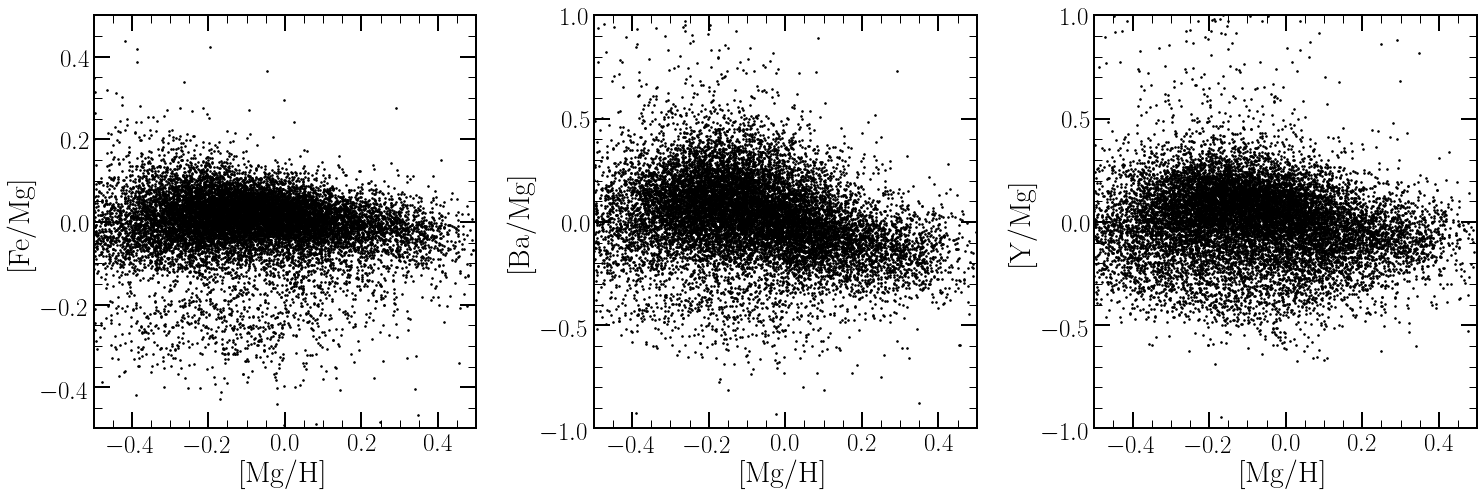

In [4]:
axes = setup_axes() 
    
def ratio(x, y): 
    # compute [X/Y] given the list of [X/H] and [Y/H] 
    return [a - b for a, b in zip(x, y)] 

kwargs = {
    "c": mpl.colors.get_named_colors_mapping()["black"], 
    "marker": ".", 
    "s": 10 
}

axes[0].scatter(data["mg"], ratio(data["fe"], data["mg"]), **kwargs) 
axes[1].scatter(data["mg"], ratio(data["ba"], data["mg"]), **kwargs) 
axes[2].scatter(data["mg"], ratio(data["y"], data["mg"]), **kwargs) 

plt.tight_layout() 
plt.show() 

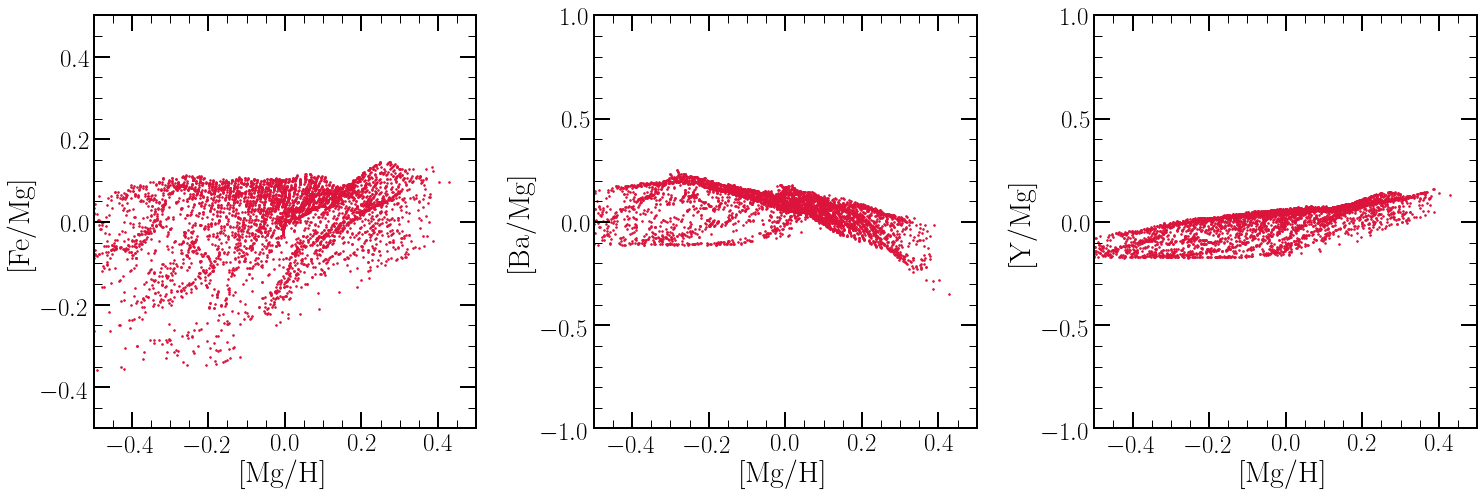

In [6]:
axes = setup_axes() 
out = vice.output("../Emily_mock") 
stars = out.stars.filter("zone_final", ">=", 50).filter("zone_final", "<=", 120) 
stellar_mass = sum(stars["mass"]) 
mass_fracs = [_ / stellar_mass for _ in stars["mass"]] 
indeces = np.random.choice(len(mass_fracs), size = 5000, p = mass_fracs) 

kwargs = {
    "c": mpl.colors.get_named_colors_mapping()["crimson"], 
    "marker": ".", 
    "s": 10 
}

stars["[fe/mg]"] = [-i for i in stars["[mg/fe]"]] 
axes[0].scatter([stars["[mg/h]"][_] for _ in indeces], 
    [stars["[fe/mg]"][_] for _ in indeces], **kwargs) 
axes[1].scatter([stars["[mg/h]"][_] for _ in indeces], 
    [stars["[ba/mg]"][_] for _ in indeces], **kwargs) 
axes[2].scatter([stars["[mg/h]"][_] for _ in indeces], 
    [stars["[y/mg]"][_] for _ in indeces], **kwargs) 

plt.tight_layout() 

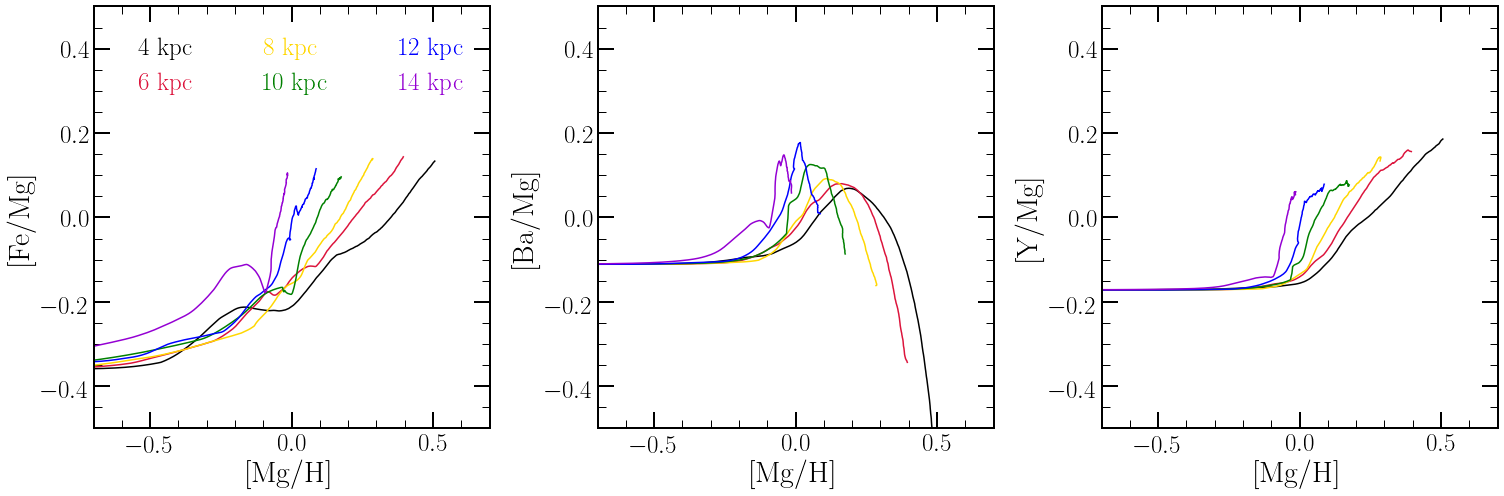

In [9]:
axes = setup_axes() 
for i in range(len(axes)): 
    axes[i].set_xlim([-0.7, 0.7]) 
    axes[i].set_ylim([-0.5, 0.5]) 
    if i: axes[i].set_yticks([-0.4, -0.2, 0.0, 0.2, 0.4]) 
out = vice.output("../Emily_mock") 

zones = ["zone20", "zone30", "zone40", "zone50", "zone60", "zone70"] 
labels = ["4 kpc", "6 kpc", "8 kpc", "10 kpc", "12 kpc", "14 kpc"] 
colors = ["black", "crimson", "gold", "green", "blue", "darkviolet"] 

for i in range(len(zones)): 
    kwargs = {
        "c": mpl.colors.get_named_colors_mapping()[colors[i]], 
        "label": labels[i] 
    } 
    zone = out.zones[zones[i]] 
    axes[0].plot(zone.history["[mg/h]"], zone.history["[fe/mg]"], **kwargs) 
    axes[1].plot(zone.history["[mg/h]"], zone.history["[ba/mg]"], **kwargs) 
    axes[2].plot(zone.history["[mg/h]"], zone.history["[y/mg]"], **kwargs) 
    
leg = axes[0].legend(loc = 9, ncol = 3, frameon = False, handlelength = 0, 
    bbox_to_anchor = (0.5, 0.98)) 
for i in range(len(leg.legendHandles)): 
    leg.get_texts()[i].set_color(colors[i]) 
    leg.legendHandles[i].set_visible(False) 

plt.tight_layout() 
plt.show() 